In [363]:
#@title Boilerplate imports {display-mode: "form"}
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.formula.api as sfa
from statsmodels.iolib.summary2 import summary_col
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy import stats
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

# Lecture 5
# Complications of inference: Multiple hypothesis testing plus "peeking" and violations of pre-determined sample size

## The problem of multiple hypothesis testing

Earlier we studied hypothesis testing and focused on error rates. We highlighted the _false positive rate_ (or "Type I error rate") as the primary error rate, which we aim to control at a specific level often denoted by $\alpha$. However, when multiple hypotheses are tested in a single analysis, the rate of *any* false positives will be higher than our specified level. The intuition behind this is simple. If each individual test has a 5 percent change of an error, then together the chance of at least one error will be greater than 5 percent.

The multiple testing problem often applies in these situations:
- Multiple outcome variables are analyzed with separate tests,
- A test is repeated on several subgroups of data,
- Several treatment or control groups are compared to each other with multiple tests, and
- A hypothesis test is conducted repeatedly over time.

### A simple case of two outcome variables

This example illustrates the inflation of error rates when we test for treatment effects on two metrics.

Imagine we have a non-profit website where we can experiment on our visitors. The visitors can engage in two activities: (1) donating money and (2) subscribing to the email news letter. Both of these are good outcomes, and we would like to increase their probability.

Let's imagine we have developed a new version of the home page and want to use an experiment to test whether it increases the probability of the visitor activities.

Suppose that the new website version actually has **no effect** on either the probability of donation or the probability of subscribing. We know that under the null hypothesis, a test with level $\alpha=0.05$ will reject in 5 percent of repeated samples. So in this simulation with no treatment effects, our probability of a mistaken conclusion about _one specific hypothesis_ is 5 percent. However, in our experiment we do **two hypothesis tests** because we are testing for a treatment effect on two variables, donation and subscription.

Let's further suppose that we declare our new page a success if  **either** of the hypothesis tests has a statistically significant result. Now our probability of making a mistaken conclusion is above 5 percent because we have two chances to make a mistake.

The probability of falsely rejecting either of the hypotheses is

$$P(\{p_\text{donate} < 0.05\} \cup \{p_\text{subscribe} < 0.05\}).$$

We can re-write this as 

$$1- P(\{p_\text{donate} \geq 0.05\} \cap \{p_\text{subscribe} \geq 0.05\}).$$

Assuming that the hypothesis tests are independent (which is a very strong and restrictive assumption) means the probability is:

$$1- P(\{p_\text{donate} \geq 0.05\})P( \{p_\text{subscribe} \geq 0.05\}) = 0.0975.$$

In general, if there are $k$ independent hypothesis tests, each with a false positive rate of $\alpha$, and all of the null hypotheses are true, then the probability of rejecting at _least one hypothesis_ will be $1 - (1 - \alpha)^k$.

#### The simulation's data-generating process

We assume a small experiment of just N=1000 visitors, half of which will be in the treatment condition. The probability of donation is 0.35, and the probability of subscription is 0.50. The treatment has no effect on either of these probabilities.

We will generate $B=5000$ repeated samples from this data-generating process to understand the false positive rates.


In [239]:
def gen_one_dataset(ATE_donate = 0, ATE_subscribe = 0):
  N = 1000
  P_donate_Y0 = 0.35
  P_subscribe_Y0 = 0.50

  # Generate potential outcomes for both donation and subscription.
  Y_donate_0 = np.random.binomial(n=1, p=P_donate_Y0, size=N)
  Y_donate_1 = np.random.binomial(n=1, p=P_donate_Y0 + ATE_donate, size=N)

  Y_subscribe_0 = np.random.binomial(n=1, p=P_subscribe_Y0, size=N)
  Y_subscribe_1 = np.random.binomial(n=1, p=P_subscribe_Y0 + ATE_subscribe, size=N)


  D = (np.arange(N) % 2 == 0).astype('float')

  df = pd.DataFrame({
      'y_donate_0': Y_donate_0,
      'y_donate_1': Y_donate_1,
      'y_subscribe_0': Y_subscribe_0,
      'y_subscribe_1': Y_subscribe_1,
      'd': D
  })
  
  # Create the two actual outcome variables.
  df['y_donate'] = df.eval("y_donate_1 * d + y_donate_0 * (1 - d)")
  df['y_subscribe'] = df.eval("y_subscribe_1 * d + y_subscribe_0 * (1 - d)")
  return df


In [240]:
def regression_ate(df, formula="y ~ d"):
  r = sfa.ols(formula, df).fit(cov_type='HC1')
  return {
      'estimated_ate': r.params['d'],
      'estimated_ate_se': r.bse['d'],
      'estimated_ate_t': r.tvalues['d'],
      # We care about detecting a positive effect of the treatment
      # so use a one-sided test.
      # The usual p-value from the regression is a two-sided test.
      'estimated_ate_p': stats.t.sf(r.tvalues['d'], r.df_resid)
  }

def results(df):
  result_donate = regression_ate(df, "y_donate ~ d")
  result_subscribe = regression_ate(df, "y_subscribe ~ d")
  return {
      'p_donate': result_donate['estimated_ate_p'],
      'p_subscribe': result_subscribe['estimated_ate_p']
  }

#### Results

The results from the B=5000 simulated experiments are below.

These show that the individual hypothesis tests have rejection rates of about 5 percent (as expected under the null hypothesis). The probability of either being rejected is about 10 percent, as we derived above.

These results means that if we declare success when either of the tests gives a significant result, then we will commit about twice as many errors as we have planned! 

In [4]:
# Simulate the experiment 5000 times
np.random.seed(94115)
B = 5000
sim = pd.DataFrame([results(gen_one_dataset()) for _ in tqdm_notebook(np.arange(0, B))])

sim['donate_is_significant'] = sim.eval("p_donate < 0.05")
sim['subscribe_is_significant'] = sim.eval("p_subscribe < 0.05")
sim['either_is_significant'] = sim.eval("donate_is_significant or subscribe_is_significant")

print("Rejection rates under the null:")
display(sim[['donate_is_significant', 'subscribe_is_significant', 'either_is_significant']].mean())

/home/aboli/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)



Rejection rates under the null:


donate_is_significant       0.0542
subscribe_is_significant    0.0466
either_is_significant       0.0986
dtype: float64

In [5]:
gen_one_dataset()

,y_donate_0,y_donate_1,y_subscribe_0,y_subscribe_1,d,y_donate,y_subscribe
0,1,1,1,0,1.0,1.0,0.0
1,0,0,0,1,0.0,0.0,0.0
2,1,1,0,0,1.0,1.0,0.0
3,0,0,0,1,0.0,0.0,0.0
4,1,1,1,0,1.0,1.0,0.0
...,...,...,...,...,...,...,...
995,0,1,0,0,0.0,0.0,0.0
996,1,1,1,1,1.0,1.0,1.0
997,0,0,0,0,0.0,0.0,0.0
998,0,0,0,1,1.0,0.0,1.0


In [6]:
results(gen_one_dataset())

{'p_donate': 0.8013551590736023, 'p_subscribe': 0.9079916242939331}

In [7]:
sim

,p_donate,p_subscribe,donate_is_significant,subscribe_is_significant,either_is_significant
0,0.143980,0.599758,False,False,False
1,0.721892,0.284829,False,False,False
2,0.092888,0.550286,False,False,False
3,0.746951,0.896921,False,False,False
4,0.421711,0.647701,False,False,False
...,...,...,...,...,...
4995,0.252752,0.329161,False,False,False
4996,0.957547,0.550276,False,False,False
4997,0.319984,0.021516,False,True,True
4998,0.654825,0.737257,False,False,False


## Error rates other than the false positive rate and some methods of controlling them

Throughout the course we have focused on the false positive rate, that is, the probability of rejecting the null hypothesis $H_0$ when it is actually true. Our notion of probability refers to the proportion of samples in infinitely repeated sampling.

Two analyze the multiple testing problem, we need definitions of error rates that can handle multiple hypotheses. Multiple hypothesis testing means that **for each data set** we will test a collection of $M$ null hypotheses $H_{0,1},H_{0,2},\ldots,H_{0,M}$. In the donation example above $M=2$.

For any set of hypothesis tests, let's call the total number of false positives $V$ and the total number of rejections $R$.

- **Family-wise error rate (FWER)**: The probability of at least one false positive, that is, mistakenly rejecting at least 1 null hypothesis out of all the hypotheses tested in the experiment. In our notation, the FWER is $P(V>1)$.
- **False discovery rate (FDR)**: The expected ratio of mistakenly rejected hypotheses to all rejected hypotheses, i.e., the expectation of $ \tfrac{\text{# false rejections}}{\text{# all rejectioms}}$. We can also write the FDR as $E[\tfrac{V}{R}].$

We will explore procedures that can control these error rates, for example, maintaining them below 0.05 even when testing many hypotheses. These procedures work by constructing alternative p-value thresholds that are smaller than 0.05. We can also use them to "correct" our p-values (make them larger) to prevent us from making too many errors.

In general, the controlling the FWER is more difficult and requires a stricter correction. That reduces the power of statistical tests. To address that the FDR was developed, which is more permissive but also allows more power.

Our explorations will use a very abstract simulation. Instead of counterfactuals and treatment effects we will simply use Normal($\mu$, $\sigma=1$) random variables. Our hypothesis tests will test the hypothesis $H_0: \mu = 0$.

Each set of hypothesis tests will be applied to a set of data from one "study". A study is a set of $N=100$ observations, each one of which has $M=80$ measurements independently drawn from Normal($\mu_m$, $\sigma=1$). That is, each study has a data set that is a (100, 80) matrix. The 80 hypothesis tests are $H_{0, m}: \mu_m = 0$ for $m=1,\ldots, M$. We implement each hypothesis test using  `scipy.stats.ttest_1samp`. 

We will examine two procedures for correcting the tests and achieving control over the FWER or FDR. 

### Bonferroni correction

Bonferroni correction is the simplest procedure and controls the FWER under general conditions. FWER control is maintained regardless of the dependence of the hypothesis tests or the proportions and true and false null hypotheses. However, the Bonferroni correction is notorious for low power when the tests are dependent.

The Bonferroni correction of $p$-values is very simple. If there are $m$ hypotheses being tested and we want to control FWER at $\alpha$, then for each hypothesis test $i=1,\ldots,M$ we reject if $p_i \leq \tfrac{\alpha}{M}$.


### Benjamini-Hochberg (BH) procedure

The Benjamini-Hochberg controls the FDR (not necessarily FWER). Because controlling FDR is less demanding than controlling FWER, the BH procedure achieves higher power. However, BH also requires some restrictions on the dependence between the hypothesis tests: They must be independent or positively correlated. The procedure is:

1. Choose a level $\alpha$ at which to control the FDR.
2. Order the $p$-values from the $M$ hypotheses tests from smallest to largest: $p_{(1)}, p_{(2)},\ldots,p_{(M)}.$
3. Find the largest $i$ such that $p_{(i)} \leq \tfrac{i}{M} \alpha$. Call it $i^*$.
4. Reject the null hypothesis for all tests with $p$-values smaller than $p_{(i^*)}$. In other words, reject all of the null hypotheses $\{H_{0,i}: i=1,\ldots,i^*\}$.


*Source:*
[Benjamini and Hochberg (1995). *Journal of the Royal Statistical Society. Series B.*](http://www.math.tau.ac.il/~ybenja/MyPapers/benjamini_hochberg1995.pdf)


### Other procedures

There are numerous procedures for controlling FDR and FWER with various tradeoffs. For example, the Benjamini-Yekutieli procedure is similar to the BH procedure requests no assumptions about the dependence of the tests. The cost of this flexibility is less power. There are a wide variety of such corrections and in general they are complex. Some only control the errors rates under certain dependence structures among the tested hypotheses. Some recently developed approaches use resampling (bootstrapping) to address dependence between tests.




## 1.1 

In [51]:
def run_one_study(effect, false_nulls=[], covariance = 0):
    N_sample_size = 100
    number_of_hypotheses = 80

    effects = np.zeros(number_of_hypotheses)
    if false_nulls != []:
        effects[false_nulls] = effect



    cov = covariance*np.ones((number_of_hypotheses , number_of_hypotheses)) + (1 - covariance)*np.eye(number_of_hypotheses)
    
    # A matrix of dimension (N_sample_size , number_of_hypotheses)
    
    dataset= np.random.multivariate_normal(mean=effects , cov=cov , size=N_sample_size)

    test_results = stats.ttest_1samp(dataset, 0)
    
    pvalues = pd.Series(test_results.pvalue)
    return pvalues

In [52]:
np.random.seed(94115)
B = 5000


pvalues_many_studies = [run_one_study(0, []) for _ in tqdm_notebook(np.arange(B))]
pvalues_uncorrected = pd.DataFrame(pvalues_many_studies)
rejections_uncorrected = (pvalues_uncorrected < 0.05).cummax(axis=1)

In [81]:
# Do a manual Bonferroni correction on the p-values and calculate the FWER

fwer_bonferroni = []
for m in np.arange(pvalues_uncorrected.shape[1]):
    
    fwer = (pvalues_uncorrected.iloc[:, 0:m] < (0.05 / (m + 1))).max(axis=1).mean()
    fwer_bonferroni.append({'m':  m, 'fwer': fwer})
  
fwer_bonferroni = pd.DataFrame(fwer_bonferroni).set_index('m')

In [82]:
## Do a Benjamini-Hochberg correction

# This is a function that gives us back another function!
# We use this to set the type of p-value correction and return just the rejection flags.
def get_multi_tester(result_type):
    def multi_test_results(pvalues_row):
        reject, pvals_corrected, _, _ = multipletests(pvalues_row, alpha=0.05, method=result_type)
        return reject
    return multi_test_results


In [84]:

fwer_bh = []
multi_test_results = get_multi_tester('fdr_bh') 
for m in tqdm_notebook(pvalues_uncorrected.columns):
    fwer = pvalues_uncorrected.loc[:, 0:m].apply(multi_test_results, axis=1, result_type='expand').max(axis=1).mean()
    fwer_bh.append({'m':  m, 'fwer': fwer})
  
fwer_bh = pd.DataFrame(fwer_bh).set_index('m')

### Commentary on simulation results

In the plot below the x-axis shows the number of (independent) null hypotheses tested. The y-axis has the FWER. The theoretical results shows that as the number of hypotheses increases it become almost certain that at least one will be rejected. Our simulation of uncorrected hypotheses tests matches the theoretical result. 

After Bonferroni correction of the tests our FWER remains constant at 0.05 regardless of the number of hypotheses tested. Note that this is a special case where all null hypotheses are true. In this case the FWER=FDR, so BH procedure also controls FWER, although in general it only controls the FDR.

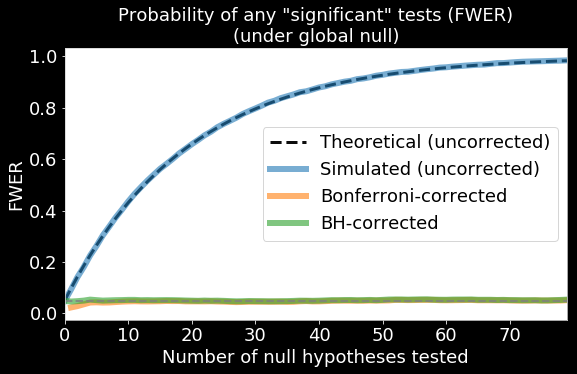

In [96]:
fwer_simulated = rejections_uncorrected.mean(axis=0)

# Generate the theoretical result we derived above:
# 1 - 0.95 ^ k
fwer_theoretical = pd.Series(1 - (0.95 ** (fwer_simulated.index.values + 1)))

ax = fwer_theoretical.plot(linestyle='--', linewidth=3, alpha=0.95, color='black', label='Theoretical (uncorrected)', figsize=(9, 5))
fwer_simulated.plot(ax=ax, linewidth=6, alpha=0.6, label='Simulated (uncorrected)')
fwer_bonferroni['fwer'].plot(ax=ax, linewidth=6, alpha=0.6, label='Bonferroni-corrected')
fwer_bh['fwer'].plot(ax=ax, linewidth=6, alpha=0.6, label='BH-corrected')

ax.legend(fontsize=18)
ax.set_title("Probability of any \"significant\" tests (FWER)\n(under global null)", color='white', fontsize=18)
ax.set_ylabel("FWER", fontsize=18)
ax.set_xlabel("Number of null hypotheses tested", fontsize=18)
ax.tick_params(labelsize=18)
ax.axhline(0.05, linewidth=2, alpha=0.8, color='grey', linestyle='--')


## Simulation to analyze power of procedures

Now we will consider the power of these hypothesis testing procedures. As usual to analyze power we will need some null hypotheses that are false. In this case we will set the first 5 measurements in the data to have a distribution of Normal($\mu=0.30$, $\sigma=1$), so that our null hypothesis of $\mu_m=0$ will be false for the first 5 columns of data. Then we can simulate the power and error rates of our procedures. 

We will compare three methods:
1. Uncorrected p-values,
2. Bonferroni correction,
3. Benjamini-Hochberg (BH) correction.

Our results will show that in terms of power they rank: Uncorrected > BH > Bonferroni.

The three approaches have very different error performance:

- The uncorrected approach has very high FWER and FDR.

- Bonferroni controls both the FWER and FDR, in this case holding them below 0.05.

- BH controls only the FDR, keeping it below 0.05, but allowing the FWER to go above.

# 1.1.2 / 1.2.1

In [221]:
def run_one_study(effect, false_nulls=[], covariance = 0):
    N_sample_size = 100
    number_of_hypotheses = 80

    # If we want to plug in an actual effect for some of
    # the measurements, we can pass a list of column numbers
    # where we want to have `effect` rather than 0.
    effects = np.zeros(number_of_hypotheses)
    if false_nulls != []:
        effects[false_nulls] = effect

    # Make an array with N_sample_size rows and number_of_hypotheses columns.
    # Each value is a draw from Normal(0, 1). We interpret this is as
    # 100 units, each having 8 measurements.  We want to test whether
    # the measurements are on average different from zero.

    cov = covariance*np.ones((number_of_hypotheses , number_of_hypotheses)) + (1 - covariance)*np.eye(number_of_hypotheses)
    
    # A matrix of dimension (N_sample_size , number_of_hypotheses)
    
    dataset= np.random.multivariate_normal(mean=effects , cov=cov , size=N_sample_size)
   
    # This function does a 1-sample t-test on each column of the data.
    # We are testing the hypothesis that the expectation of the column
    # is 0.
    test_results = stats.ttest_1samp(dataset, 0)
    
    pvalues = pd.Series(test_results.pvalue)
    return pvalues

In [222]:
B = 5000
np.random.seed(94115)
# Set the first 5 hypotheses to have an effect (loc!=0).
# The remainder have no effect (loc=0).
indices_has_effect = [0,1,2,3,4]
pvalues_many_studies = [run_one_study(effect = 0.3, false_nulls = indices_has_effect, covariance = 0.95) for _ in tqdm_notebook(np.arange(B))]
pvalues_uncorrected = pd.DataFrame(pvalues_many_studies)
rejections_uncorrected = (pvalues_uncorrected < 0.05).cummax(axis=1)

In [223]:
def fdr(reject_corrected, indices_has_effect=indices_has_effect):
  # Assumes that the first few indices can have true effects
  # but the remaining columns will have true null hypotheses.
  discoveries = reject_corrected.sum(axis=1)
  false_discoveries = reject_corrected.loc[:, (indices_has_effect[-1] + 1):].sum(axis=1)
  # False discovery quotient is defined as 0 when there are no rejections.
  return (false_discoveries / discoveries).fillna(0).mean()

def fwer(reject_corrected, indices_has_effect=indices_has_effect):
  # Assumes that the first few indices can have true effects
  # but the remaining columns will have true null hypotheses.
  any_false_discoveries = reject_corrected.loc[:, (indices_has_effect[-1] + 1):].max(axis=1)
  # False discovery quotient is defined as 0 when there are no rejections.
  return any_false_discoveries.mean()


### Uncorrected (raw p-values from t-test)

The results show that uncorrected tests in this case (80 hypothesis tests, effect of 0.30) have a power of about 0.84. That is, in the 5 cases where $\mu_m=0.30$, our test had about a 84 percent chance of detecting this.

The FDR is about 0.45, and the FWER is about 0.98. These high error rates are expected because we are testing many hypotheses without any correction.

In [66]:
reject_uncorrected = (pvalues_uncorrected < 0.05)

# Power using bonferroni correction
print("Power for the first 5 tests (uncorrected):")
print(reject_uncorrected.loc[:, indices_has_effect].mean(axis=0))


print("\nFWER (uncorrected) = ", fwer(reject_uncorrected))
print("\nFDR (uncorrected) = ", fdr(reject_uncorrected))

Power for the first 5 tests (uncorrected):
0    0.8452
1    0.8454
2    0.8398
3    0.8446
4    0.8404
dtype: float64

FWER (uncorrected) =  0.1482

FDR (uncorrected) =  0.11615995750388222


In [225]:
def get_multi_tester(result_type):
    def multi_test_results(pvalues_row):
        reject, pvals_corrected, _, _ = multipletests(pvalues_row, alpha=0.05, method=result_type)
        return reject
    return multi_test_results

In [226]:
multi_test_results = get_multi_tester('bonferroni') 
reject_corrected = pvalues_uncorrected.apply(multi_test_results, axis=1, result_type='expand')

# Power using bonferroni correction
print("Power for the first 5 tests (Bonferroni):")
print(reject_corrected.loc[:, indices_has_effect].mean(axis=0))


print("\nFWER (Bonferroni) = ", fwer(reject_corrected))
print("\nFDR (Bonferroni) = ", fdr(reject_corrected))

Power for the first 5 tests (Bonferroni):
0    0.3052
1    0.3060
2    0.3094
3    0.3046
4    0.3062
dtype: float64

FWER (Bonferroni) =  0.0032

FDR (Bonferroni) =  0.0025452847021243245


In [227]:
Sensitivity_BF = np.mean(reject_corrected[indices_has_effect].sum(axis = 1)/ len(indices_has_effect))
Sensitivity_BF

0.30628000000000055

In [228]:
multi_test_results = get_multi_tester('fdr_bh') 
reject_corrected = pvalues_uncorrected.apply(multi_test_results, axis=1, result_type='expand')

# Power using BH correction
print("Power for the first 5 tests (BH):")
print(reject_corrected.loc[:, indices_has_effect].mean(axis=0))

print("\nFWER (BH) = ", fwer(reject_corrected))
print("\nFDR (BH) = ", fdr(reject_corrected))

Power for the first 5 tests (BH):
0    0.4332
1    0.4314
2    0.4322
3    0.4298
4    0.4324
dtype: float64

FWER (BH) =  0.0222

FDR (BH) =  0.021134529212168948


In [229]:
Sensitivity_BH = np.mean(reject_corrected[indices_has_effect].sum(axis = 1)/ len(indices_has_effect))
Sensitivity_BH

0.4317999999999992

# 1.1.3

In [235]:
def get_multi_tester(result_type):
    def multi_test_results(pvalues_row):
        reject, pvals_corrected, _, _ = multipletests(pvalues_row, alpha=0.01, method=result_type)
        return reject
    return multi_test_results

### Bonferroni correction results


In [236]:
multi_test_results = get_multi_tester('bonferroni') 
reject_corrected = pvalues_uncorrected.apply(multi_test_results, axis=1, result_type='expand')

# Power using bonferroni correction
print("Power for the first 5 tests (Bonferroni):")
print(reject_corrected.loc[:, indices_has_effect].mean(axis=0))


print("\nFWER (Bonferroni) = ", fwer(reject_corrected))
print("\nFDR (Bonferroni) = ", fdr(reject_corrected))

Power for the first 5 tests (Bonferroni):
0    0.1712
1    0.1702
2    0.1714
3    0.1720
4    0.1696
dtype: float64

FWER (Bonferroni) =  0.001

FDR (Bonferroni) =  0.000705406746031746


# 1.1.4

In [71]:
reject_bonferroni_correction = (pvalues_uncorrected < (0.01/pvalues_uncorrected.shape[1]))


print("Power for the first 5 tests (Bonferroni):")
print(reject_bonferroni_correction[indices_has_effect].mean(axis = 0))

print("\nFWER (Bonferroni) = ", fwer(reject_bonferroni_correction))
print("\nFDR (Bonferroni) = ", fdr(reject_bonferroni_correction))

Power for the first 5 tests (Bonferroni):
0    0.1712
1    0.1702
2    0.1714
3    0.1720
4    0.1696
dtype: float64

FWER (Bonferroni) =  0.001

FDR (Bonferroni) =  0.000705406746031746


### Benjamini-Hochberg method results



In [98]:
B = 5000
np.random.seed(94115)
# Set the first 5 hypotheses to have an effect (loc!=0).
# The remainder have no effect (loc=0).
indices_has_effect = [0,1,2,3,4]
pvalues_many_studies = [run_one_study(effect = 0.3, false_nulls = indices_has_effect, covariance = 0) for _ in tqdm_notebook(np.arange(B))]
pvalues_uncorrected = pd.DataFrame(pvalues_many_studies)
rejections_uncorrected = (pvalues_uncorrected < 0.05).cummax(axis=1)

In [99]:
multi_test_results = get_multi_tester('bonferroni') 
reject_corrected = pvalues_uncorrected.apply(multi_test_results, axis=1, result_type='expand')

# Power using bonferroni correction
print("Power for the first 5 tests (Bonferroni):")
print(reject_corrected.loc[:, indices_has_effect].mean(axis=0))


print("\nFWER (Bonferroni) = ", fwer(reject_corrected))
print("\nFDR (Bonferroni) = ", fdr(reject_corrected))

Power for the first 5 tests (Bonferroni):
0    0.3064
1    0.2966
2    0.3174
3    0.3064
4    0.3012
dtype: float64

FWER (Bonferroni) =  0.049

FDR (Bonferroni) =  0.023536666666666647


In [100]:
Sensitivity_BF = np.mean(reject_corrected[indices_has_effect].sum(axis = 1)/ len(indices_has_effect))
Sensitivity_BF

0.3056000000000119

In [101]:
multi_test_results = get_multi_tester('fdr_bh') 
reject_corrected = pvalues_uncorrected.apply(multi_test_results, axis=1, result_type='expand')

# Power using BH correction
print("Power for the first 5 tests (BH):")
print(reject_corrected.loc[:, indices_has_effect].mean(axis=0))

print("\nFWER (BH) = ", fwer(reject_corrected))
print("\nFDR (BH) = ", fdr(reject_corrected))

Power for the first 5 tests (BH):
0    0.4226
1    0.4190
2    0.4258
3    0.4164
4    0.4114
dtype: float64

FWER (BH) =  0.1408

FDR (BH) =  0.04597761904761904


In [102]:
Sensitivity_BH = np.mean(reject_corrected[indices_has_effect].sum(axis = 1)/ len(indices_has_effect))
Sensitivity_BH

0.4190400000000036

## 1.2.4

In [274]:
def gen_one_dataset(ATE_donate = 0, ATE_email = 0):
  N = 1000
  P_donate_Y0 = 0.35
  P_email_Y0 = 0.50

  # Generate potential outcomes for both donation and subscription.
  Y_donate_0 = np.random.binomial(n=1, p=P_donate_Y0, size=N)
  Y_donate_1 = np.random.binomial(n=1, p=P_donate_Y0 + ATE_donate, size=N)

  Y_email_0 = np.random.binomial(n=1, p=P_email_Y0, size=N)
  Y_email_1 = np.random.binomial(n=1, p=P_email_Y0 + ATE_email, size=N)

  # Assign even numbered units to treatment.
  # A simple way to do a completely randomized 50/50 split.
  D = (np.arange(N) % 2 == 0).astype('float')

  df = pd.DataFrame({
      'y_donate_0': Y_donate_0,
      'y_donate_1': Y_donate_1,
      'y_email_0': Y_email_0,
      'y_email_1': Y_email_1,
      'd': D
  })
  
  # Create the two actual outcome variables.
  df['y_donate'] = df.eval("y_donate_1 * d + y_donate_0 * (1 - d)")
  df['y_email'] = df.eval("y_email_1 * d + y_email_0 * (1 - d)")
  return df


In [277]:
def regression_ate(df, formula="y ~ d"):
  r = sfa.ols(formula, df).fit(cov_type='HC1')
  return {
      'estimated_ate': r.params['d'],
      'estimated_ate_se': r.bse['d'],
      'estimated_ate_t': r.tvalues['d'],
      # We care about detecting a positive effect of the treatment
      # so use a one-sided test.
      # The usual p-value from the regression is a two-sided test.
      'estimated_ate_p': stats.t.sf(r.tvalues['d'], r.df_resid)
  }

def results(df):
  result_donate = regression_ate(df, "y_donate ~ d")
  result_email = regression_ate(df, "y_email ~ d")
  return {
      'p_donate': result_donate['estimated_ate_p'],
      'p_email': result_email['estimated_ate_p']
  }

In [278]:
# Simulate the experiment 5000 times
np.random.seed(94115)
B = 5000
sim = pd.DataFrame([results(gen_one_dataset()) for _ in tqdm_notebook(np.arange(0, B))])

sim['donate_is_significant'] = sim.eval("p_donate < 0.224")
sim['email_is_significant'] = sim.eval("p_email < 0.224")
sim['either_is_significant'] = sim.eval("donate_is_significant or email_is_significant")
sim['both_significant'] = sim.eval("donate_is_significant and email_is_significant")
print("Rejection rates under the null:")
display(sim[['donate_is_significant', 'email_is_significant', 'either_is_significant', 'both_significant']].mean())

Rejection rates under the null:


donate_is_significant    0.2266
email_is_significant     0.2094
either_is_significant    0.3864
both_significant         0.0496
dtype: float64

## Donation website experiment: Applying multiple hypothesis testing corrections

Let's go back to the world of section "Donation website: An experiment with 2 outcomes of interest" where we are interested in the effect of the new website on dontations and email subscriptions.

We will apply the multiple hypothesis testing corrections to the experiment.

In [247]:
# First let's verify Bonferroni correction on the original simulation.

sim['donate_is_significant'] = sim.eval("p_donate < 0.025")
sim['subscribe_is_significant'] = sim.eval("p_subscribe < 0.025")
sim['either_is_significant'] = sim.eval("donate_is_significant or subscribe_is_significant")
#sim['both_are_significant'] = sim.eval("donate_is_significant and subscribe_is_significant")

print("Rejection rates under the null:")
print(sim[['donate_is_significant', 'subscribe_is_significant', 'either_is_significant']].mean())


Rejection rates under the null:
donate_is_significant       0.0248
subscribe_is_significant    0.0292
either_is_significant       0.0534
dtype: float64


### Note: Let's change the DGP!

To make things more interesting we will **modify the data-generating process** so that one of the behaviors **is** affected by the treatment.

Assume that the treatment **increases the probability of subscription by 0.05**, but it has no effect on donation. In our simulation, we will plug in this modification.

In [21]:
# Simulate the experiment 5000 times.
# We have plugged in an effect of 0.1.
np.random.seed(94115)
B = 500
ATE_subscription = 0.05
sim_only_sub_effect = pd.DataFrame(
    [results(gen_one_dataset(0, ATE_subscription)) for _ in tqdm_notebook(np.arange(0, B))]
)

In [22]:
print("Rejection rate, uncorrected")
print((sim_only_sub_effect < 0.05).mean())

print("Rejection rate w/ Bonferroni correction")
print((sim_only_sub_effect < 0.025).mean())

Rejection rate, uncorrected
p_donate       0.032
p_subscribe    0.488
dtype: float64
Rejection rate w/ Bonferroni correction
p_donate       0.018
p_subscribe    0.370
dtype: float64


In [23]:

# Get rejections using BH correction
multi_test_results = get_multi_tester('fdr_bh')
sim_reject_bh = sim_only_sub_effect[['p_donate', 'p_subscribe']].apply(multi_test_results, axis=1, result_type='expand')

# Calculate the FDR
# Rejections in the first column mean we said there was
# a statistically significant effect on donations, which is
# a false rejection.
# Rejections in the second column means we found a statistically
# significant effect on subscription, which would be a true rejection.

# FDR is false rejections / all rejections.
false_rejections = sim_reject_bh.iloc[:, 0].astype('float')
all_rejections = sim_reject_bh.sum(axis=1)
print("FDR = ",(false_rejections / all_rejections).mean())
print("Power (subscription effect) =", sim_reject_bh.iloc[:, 1].mean())
print("Rejection rate (donation effect) =", sim_reject_bh.iloc[:, 0].mean())


FDR =  0.04922279792746114
Power (subscription effect) = 0.374
Rejection rate (donation effect) = 0.026


## The problem of a non-fixed sample size

### Stopping experiments early ("peeking") and continuing an experiment until significant results



A key, but subtle assumption, in the conventional hypothesis testing approach is that the sample size is fixed ahead of time and we only test our hypothesis at the end of the experiment. Violating that assumption can inflate false positive rates.

Suppose that a researcher has planned an experiment using power analysis to set a target sample size of $N$. In practice, the fixed sample size assumption may be violated in a couple of ways. 

1. Early stopping: This is also informally called "peeking". The early stopping problem occurs when the researcher stops the experiment based on results before the planned sample size is reached. For example, the reseacher might check the results of the experiment each day. When the $t$-test happens to have a p-value below 0.05 the researcher stops the experiment and declares a statistically significant result. 
2. Continuation: The researcher might reach a sample size of $N$ and conduct a $t$-test as planned. Suppose that no significant result is found, but the researcher continues to collect data in hopes of the result changing. 

### Early stopping

Peeking is the first case we will explore.

In the example below we have an experiment with two equally-sized groups. The measurements from each group are normally distributed: Normal(0, 1) in the control group and Normal(ATE, 1) in the treatment group. We will set ATE=0 and have a true null hypothesis.

To (dramatically) speed up the simulations we have constructed the data using only `numpy` and without explicit machinery for the potential outcomes model.

We will use a $t$-test to test the hypothesis of ATE=0, but we will conduct this test after every pair of observations (one from control, one from treatment). For our experiment with N=200, this means we will have a sequence of $t$-test results and $p$-values. We can number the $p$-values: $p_2, p_4, \ldots, p_{200}$.

We are interested in the overall false positive rate if we stop and declare a statistically significant effect the first time any of the $p$-values is below 0.05. (*Note: This can also be viewed as the FWER over the sequence of hypothesis tests.*) We will compare this false positive rate to the one we get from testing the hypothesis only at the end of the experiment, which we know should match our chosen false positive rate ($\alpha= 0.05$).

Our first steps are to set up a data-generating process and functions to conduct the hypothesis tests.



# 2.1
Let’s repeat the section “Simulating the ‘peeking’ experiments". However we will peek less
frequently. We started with N = 200, but let’s suppose we only peek once per day instead
of after every new pair of data points. We are a small website so we get just 50 visitors
per day. You just need to modify n_index = np.arange(4, df.shape[0]). See the
np.arange documentation on how to get only every k-th number in the range. How does
decreasing the peeking frequency affect your false positive rate?

In [357]:
def gen_one_dataset(N=200, ATE = 0):
  """Make data from one experiment with a specified ATE.
  
  
  To speed things up we split the sample in two and put
  the control group in the first column and the treatment
  group in the second column.
  """

  # potential outcomes are normally distributed
  Y_control = np.random.normal(loc=0, size=(int(N / 2), 1))
  Y_treatment = np.random.normal(loc=ATE, size=(int(N / 2), 1))

  # Stack the groups side by side in a (100, 2) array.
  return np.hstack((Y_control, Y_treatment))

In [382]:
def gen_pvalue_sequence(N):
  # Make data from one experiment
  df = gen_one_dataset(N=N)

  n_index = np.arange(25, df.shape[0]+25,25)
  # Note that we index the dataframe starting at 1 for correct plotting

  running_pvalues = pd.Series(np.array([get_pvalue_analysis(df[0:n, :]) for n in n_index]), index= 2*(n_index))
  return running_pvalues

def get_pvalue_analysis(df):    
    """Do a two-sample t-test to get the p-value."""
    results = stats.ttest_ind(df[:, 0], df[:, 1])
    return results.pvalue

### Simulating the "peeking" experiments

We fix the sample size at $N=200$ for our simulations then run $B=1000$ experiments.

To calculate the results we check for the first test $i=2,4,\ldots,200$ where $p_i < 0.05$. We will calculate the percentage of tests with $i<200$, meaning they were "significant" before the experiment ended. Then we will calculate the number of experiments where we rejected the null hypothesis with the full sample.

The results below show that as expected about 5 percent of hypotheses were rejected when tested with the full sample. However, nearly **35 percent** of the experiments had at least one $p$-value below 0.05 before the experiment ended. Therefore, the sequential FWER in this case is 35 percent. If we were to follow the peeking strategy in this way, we would declare a positive result more than one third of the time although there is no effect!

In [383]:
np.random.seed(94115)
B = 1000 # simulate 1000 experiments
N = 200
sims_peeking_experiments = pd.DataFrame([gen_pvalue_sequence(N=N) for _ in tqdm_notebook(np.arange(B))]).T

In [384]:
# For each experiment, find the first test where the p-value was below 0.05.
first_significant_row = sims_peeking_experiments[sims_peeking_experiments < 0.05].idxmin(axis=0)

# Check if our test was ever "significant" before we reached the end of the experiment.
is_significant_early = (first_significant_row < N).fillna(False)  # Note that we switched to indexing starting at 1

# Check if the test was "significant" at the end of the experiment,
# i.e., the last row, when we have reached the pre-determined sample size
is_significant_at_full_sample = (sims_peeking_experiments.tail(1) < 0.05)

results_of_experiments = pd.DataFrame({
    'is_significant_at_full_sample': is_significant_at_full_sample.T.values.flatten(),
    'is_significant_early': is_significant_early.values

})

In [393]:
# Print errors rates from experiment simulations
results_of_experiments.mean()

is_significant_at_full_sample    0.051
is_significant_early             0.104
dtype: float64

In [397]:
sims_peeking_experiments

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
50,0.660435,0.305050,0.905343,0.036688,0.371164,0.793036,0.357953,0.721784,0.655982,0.835026,...,0.105353,0.042225,0.775648,0.623635,0.437211,0.258024,0.170648,0.410759,0.366363,0.649714
100,0.769125,0.113116,0.810388,0.163247,0.522797,0.196550,0.688521,0.704345,0.919173,0.480514,...,0.392883,0.137492,0.248997,0.523957,0.962558,0.641736,0.308029,0.800269,0.389778,0.617628
150,0.269472,0.363725,0.600440,0.303814,0.275876,0.493776,0.696014,0.494617,0.716399,0.975323,...,0.539624,0.308551,0.714236,0.803897,0.157630,0.636146,0.693500,0.523722,0.142994,0.574297
200,0.074953,0.555965,0.373777,0.535568,0.135861,0.579778,0.345221,0.115400,0.897351,0.588723,...,0.798476,0.562794,0.820976,0.538692,0.059747,0.875422,0.681040,0.207729,0.038347,0.523273


Text(0.5, 1.0, '$p$-value trace from experiment 3')

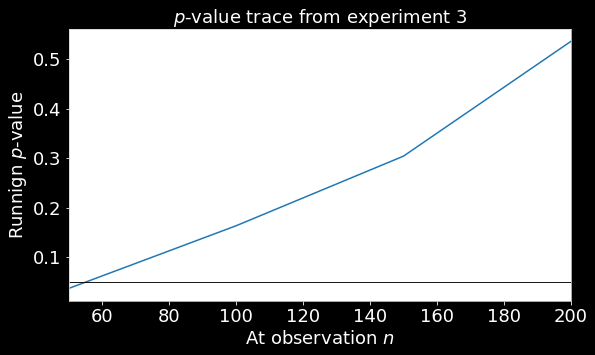

In [394]:
ax = sims_peeking_experiments.loc[:, 3].plot(figsize=(9,5))
ax.axhline(0.05, alpha=0.9, color='black', linewidth=1)
#ax.set_ylim(-0.025, 1.025)
ax.set_xlabel(r"At observation $n$", fontsize=18)
ax.set_ylabel(r"Runnign $p$-value", fontsize=18)
ax.tick_params(labelsize=18)
ax.set_title(r"$p$-value trace from experiment 3", fontsize=18, color='white')

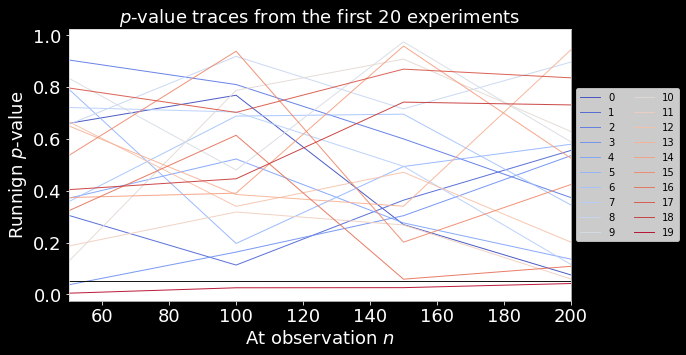

In [396]:
ax = sims_peeking_experiments.loc[:, 0:19].plot(figsize=(9,5), colormap='coolwarm', linewidth=1, alpha=0.9)
ax.axhline(0.05, alpha=0.9, color='black', linewidth=1)
ax.set_ylim(-0.025, 1.025)
ax.set_xlabel(r"At observation $n$", fontsize=18)
ax.set_ylabel(r"Runnign $p$-value", fontsize=18)
ax.tick_params(labelsize=18)
ax.set_title(r"$p$-value traces from the first 20 experiments", fontsize=18, color='white')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

## 2.3

In [406]:
def gen_one_dataset(N=5000, ATE = 0):
  """Make data from one experiment with a specified ATE.
  
  
  To speed things up we split the sample in two and put
  the control group in the first column and the treatment
  group in the second column.
  """

  # potential outcomes are normally distributed
  Y_control = np.random.normal(loc=0, size=(int(N / 2), 1))
  Y_treatment = np.random.normal(loc=ATE, size=(int(N / 2), 1))

  # Stack the groups side by side in a (100, 2) array.
  return np.hstack((Y_control, Y_treatment))

In [407]:
def gen_pvalue_sequence(N):
  # Make data from one experiment
  df = gen_one_dataset(N=N)

  n_index = np.arange(4, df.shape[0])

  running_pvalues = pd.Series(np.array([get_pvalue_analysis(df[0:n, :]) for n in n_index]), index=2 * (n_index + 1))
  return running_pvalues

def get_pvalue_analysis(df):    
    """Do a two-sample t-test to get the p-value."""
    results = stats.ttest_ind(df[:, 0], df[:, 1])
    return results.pvalue

In [408]:
np.random.seed(94115)
B = 500
N = 5000
sims_peeking_experiments = pd.DataFrame([gen_pvalue_sequence(N=N) for _ in tqdm_notebook(np.arange(B))]).T

In [409]:
# For each experiment, find the first test where the p-value was below 0.05.
first_significant_row = sims_peeking_experiments[sims_peeking_experiments < 0.05].idxmin(axis=0)

# Check if our test was ever "significant" before we reached the end of the experiment.
is_significant_early = (first_significant_row < N).fillna(False)  # Note that we switched to indexing starting at 1

# Check if the test was "significant" at the end of the experiment,
# i.e., the last row, when we have reached the pre-determined sample size
is_significant_at_full_sample = (sims_peeking_experiments.tail(1) < 0.05)

results_of_experiments = pd.DataFrame({
    'is_significant_at_full_sample': is_significant_at_full_sample.T.values.flatten(),
    'is_significant_early': is_significant_early.values

})

In [410]:
# Print errors rates from experiment simulations
results_of_experiments.mean()

is_significant_at_full_sample    0.050
is_significant_early             0.568
dtype: float64

Text(0.5, 1.0, '$p$-value trace from experiment 3')

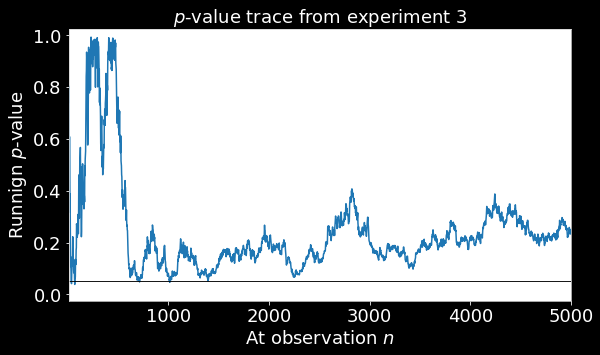

In [411]:
ax = sims_peeking_experiments.loc[:, 3].plot(figsize=(9,5))
ax.axhline(0.05, alpha=0.9, color='black', linewidth=1)
ax.set_ylim(-0.025, 1.025)
ax.set_xlabel(r"At observation $n$", fontsize=18)
ax.set_ylabel(r"Runnign $p$-value", fontsize=18)
ax.tick_params(labelsize=18)
ax.set_title(r"$p$-value trace from experiment 3", fontsize=18, color='white')

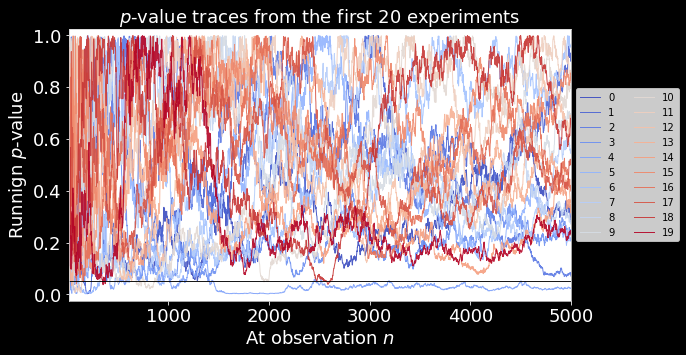

In [412]:
ax = sims_peeking_experiments.loc[:, 0:19].plot(figsize=(9,5), colormap='coolwarm', linewidth=1, alpha=0.9)
ax.axhline(0.05, alpha=0.9, color='black', linewidth=1)
ax.set_ylim(-0.025, 1.025)
ax.set_xlabel(r"At observation $n$", fontsize=18)
ax.set_ylabel(r"Runnign $p$-value", fontsize=18)
ax.tick_params(labelsize=18)
ax.set_title(r"$p$-value traces from the first 20 experiments", fontsize=18, color='white')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)